   Diabetes_012  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0           0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1           0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2           0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3           0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4           0.0     1.0       1.0        1.0  24.0     0.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  AnyHealthcare  \
0                   0.0           0.0     0.0  ...            1.0   
1                   0.0           1.0     0.0  ...            0.0   
2                   0.0           0.0     1.0  ...            1.0   
3                   0.0           1.0     1.0  ...            1.0   
4                   0.0           1.0     1.0  ...            1.0   

   NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex   Age  Education  \
0          0.0      5.0      18.0      15.0       1.0  0.0   9.0        4.0   
1     

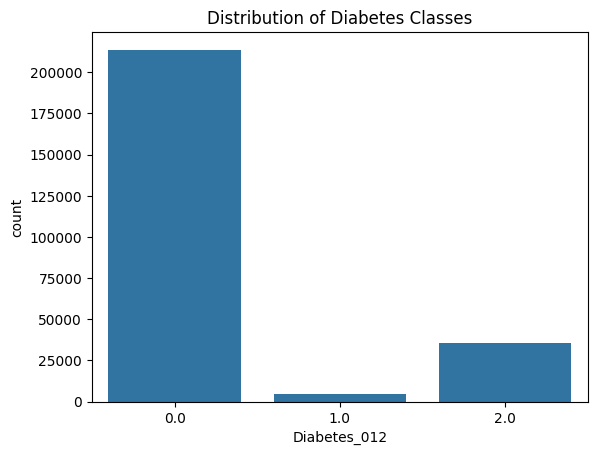

Diabetes_012            0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64


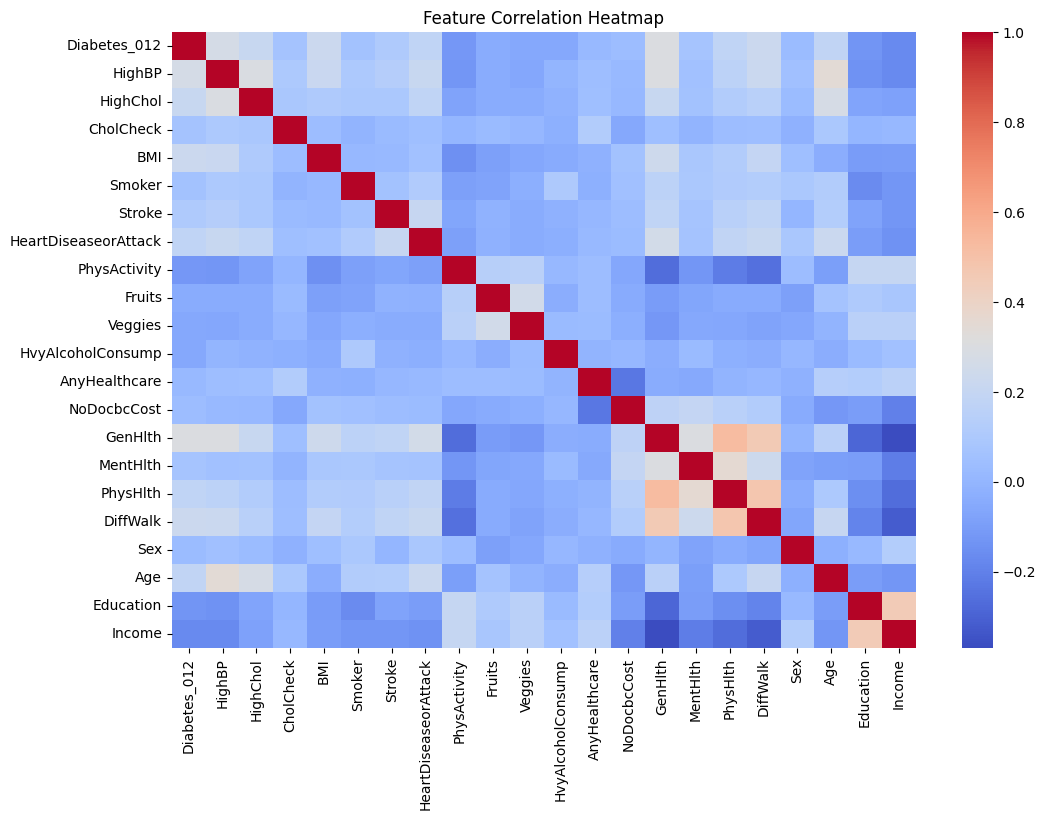

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data (replace with your file path or DataFrame)
df = pd.read_csv('diabetes_012_health_indicators_BRFSS2015.csv')

# Quick look at the data
print(df.head())
print(df.info())

# Target variable distribution
sns.countplot(x='Diabetes_012', data=df)
plt.title('Distribution of Diabetes Classes')
plt.show()

# Check for missing values
print(df.isnull().sum())

# Correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# Pairplot for a subset of features
# sns.pairplot(df, hue='Diabetes_012', vars=['BMI','Age','HighBP','HighChol'])
# plt.show()


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Features and target
X = df.drop('Diabetes_012', axis=1)
y = df['Diabetes_012']

# Train-test split (stratify to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


<Figure size 1000x600 with 0 Axes>

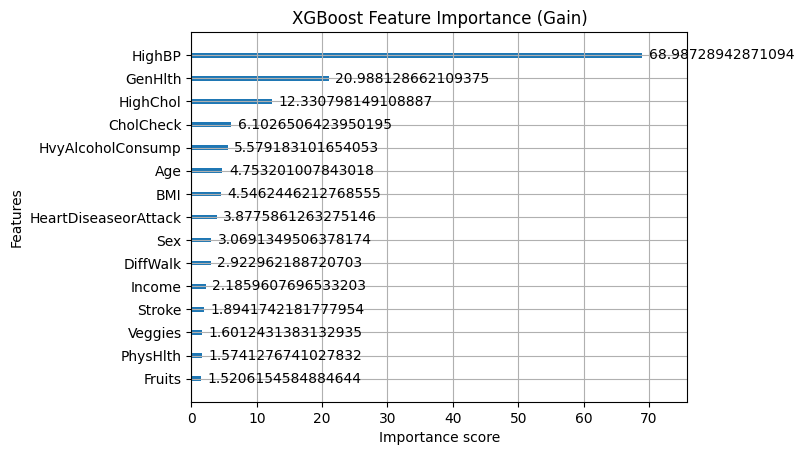

In [4]:
from xgboost import plot_importance

# Plot feature importance
plt.figure(figsize=(10, 6))
plot_importance(xgb, importance_type='gain', max_num_features=15)  # 'gain' is the most informative
plt.title('XGBoost Feature Importance (Gain)')
plt.show()


In [5]:
# Create a new dataframe with only the top 10 features
top_features = ['HighBP', 'GenHlth', 'HighChol', 'CholCheck', 'HvyAlcoholConsump',
                'Age', 'BMI', 'HeartDiseaseorAttack', 'Sex', 'DiffWalk']

# Select only these features
X_top = df[top_features]
y = df['Diabetes_012']

# Check class distribution
print("Class distribution:")
print(y.value_counts())
print(y.value_counts(normalize=True).round(3))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_top, y, test_size=0.25, random_state=42, stratify=y)



Class distribution:
Diabetes_012
0.0    213703
2.0     35346
1.0      4631
Name: count, dtype: int64
Diabetes_012
0.0    0.842
2.0    0.139
1.0    0.018
Name: proportion, dtype: float64


In [6]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# STAGE 1: Binary classifier to distinguish class 0 from classes 1 & 2
print("\n--- Stage 1: No Diabetes vs Any Diabetes ---")

# Create binary labels for first stage
y_train_binary = (y_train > 0).astype(int)  # 0 for no diabetes, 1 for any diabetes
y_test_binary = (y_test > 0).astype(int)

# Undersample majority class (class 0) for stage 1
undersampler_s1 = RandomUnderSampler(sampling_strategy=0.5, random_state=42)  # 1:1 ratio
X_train_under_s1, y_train_binary_under = undersampler_s1.fit_resample(X_train, y_train_binary)

print("Stage 1 training distribution after undersampling:")
print(pd.Series(y_train_binary_under).value_counts())

# Train stage 1 model: No diabetes (0) vs Any diabetes (1+2)
model_stage1 = XGBClassifier(
    objective='binary:logistic',  # Binary classification
    eval_metric='logloss',
    use_label_encoder=False,
    max_depth=4,
    n_estimators=300,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5
)

model_stage1.fit(X_train_under_s1, y_train_binary_under)

# Evaluate stage 1 model
y_pred_stage1 = model_stage1.predict(X_test)
print("\nStage 1 Classification Report:")
print(classification_report(y_test_binary, y_pred_stage1, digits=3))

# STAGE 2: Binary classifier to distinguish class 1 from class 2
print("\n--- Stage 2: Prediabetes vs Diabetes ---")

# Filter training data to only include classes 1 and 2
mask_train_s2 = y_train.isin([1, 2])
X_train_s2 = X_train[mask_train_s2]
y_train_s2 = y_train[mask_train_s2]
# Convert to binary: 0 for class 1, 1 for class 2
y_train_s2 = (y_train_s2 == 2).astype(int)

print("Original stage 2 training distribution:")
print(pd.Series(y_train_s2).value_counts())

# Apply SMOTE to balance classes 1 and 2
smote_s2 = SMOTE(sampling_strategy=0.8, random_state=42)  # Create more balanced dataset
X_train_s2_resampled, y_train_s2_resampled = smote_s2.fit_resample(X_train_s2, y_train_s2)

print("Stage 2 training distribution after resampling:")
print(pd.Series(y_train_s2_resampled).value_counts())

# Train stage 2 model with class weights to emphasize class 1 (now encoded as 0)
class_weights_s2 = {0: 3.0, 1: 1.0}  # Higher weight for prediabetes (class 1, encoded as 0)
sample_weights_s2 = np.ones(len(y_train_s2_resampled))
for cls, weight in class_weights_s2.items():
    sample_weights_s2[y_train_s2_resampled == cls] = weight

model_stage2 = XGBClassifier(
    objective='binary:logistic',  # Binary classification
    eval_metric='logloss',
    use_label_encoder=False,
    max_depth=3,  # Slightly lower to avoid overfitting
    n_estimators=300,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5
)

model_stage2.fit(X_train_s2_resampled, y_train_s2_resampled, sample_weight=sample_weights_s2)

# COMBINING BOTH STAGES
print("\n--- Combining Both Stages ---")

# Get probabilities for both stages
stage1_proba = model_stage1.predict_proba(X_test)[:, 1]  # Prob of being class 1 or 2
stage2_proba = model_stage2.predict_proba(X_test)[:, 1]  # Prob of being class 2 vs class 1

# Initialize final predictions
cascade_preds = np.zeros(len(X_test), dtype=int)

# Decision logic with threshold tuning:
for i in range(len(X_test)):
    if stage1_proba[i] < 0.5:  # Predicted as class 0
        cascade_preds[i] = 0
    else:  # Predicted as not class 0
        # Adjust threshold to favor class 1 (using 0.6 instead of 0.5)
        if stage2_proba[i] < 0.6:  # Lower threshold favors class 1 predictions
            cascade_preds[i] = 1
        else:
            cascade_preds[i] = 2

# Evaluate the cascading model
print("\nCascading Model Classification Report:")
print(classification_report(y_test, cascade_preds, digits=3))

# Analyze confusion matrix
print("\nCascading Model Confusion Matrix:")
print(confusion_matrix(y_test, cascade_preds))

# Optional: Try different threshold for stage 1 to further optimize
adjusted_cascade_preds = np.zeros(len(X_test), dtype=int)
for i in range(len(X_test)):
    # More conservative threshold for declaring any diabetes
    if stage1_proba[i] < 0.45:  # More samples will be predicted as class 0
        adjusted_cascade_preds[i] = 0
    else:
        # Even more favorable threshold for class 1
        if stage2_proba[i] < 0.65:
            adjusted_cascade_preds[i] = 1
        else:
            adjusted_cascade_preds[i] = 2

print("\nAdjusted Threshold Cascading Model Classification Report:")
print(classification_report(y_test, adjusted_cascade_preds, digits=3))
print("\nAdjusted Threshold Confusion Matrix:")
print(confusion_matrix(y_test, adjusted_cascade_preds))


--- Stage 1: No Diabetes vs Any Diabetes ---
Stage 1 training distribution after undersampling:
Diabetes_012
0    59966
1    29983
Name: count, dtype: int64


c:\Users\Maryna24\Desktop\Factoria\Proyectos\MODULOII\multiclase-classifier_e2\multiclase-classifier_e2\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:03:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Stage 1 Classification Report:
              precision    recall  f1-score   support

           0      0.916     0.849     0.881     53426
           1      0.420     0.585     0.489      9994

    accuracy                          0.808     63420
   macro avg      0.668     0.717     0.685     63420
weighted avg      0.838     0.808     0.820     63420


--- Stage 2: Prediabetes vs Diabetes ---
Original stage 2 training distribution:
Diabetes_012
1    26510
0     3473
Name: count, dtype: int64
Stage 2 training distribution after resampling:
Diabetes_012
1    26510
0    21208
Name: count, dtype: int64


c:\Users\Maryna24\Desktop\Factoria\Proyectos\MODULOII\multiclase-classifier_e2\multiclase-classifier_e2\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:03:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Combining Both Stages ---

Cascading Model Classification Report:
              precision    recall  f1-score   support

         0.0      0.916     0.849     0.881     53426
         1.0      0.037     0.243     0.064      1158
         2.0      0.432     0.305     0.358      8836

    accuracy                          0.762     63420
   macro avg      0.462     0.466     0.434     63420
weighted avg      0.833     0.762     0.793     63420


Cascading Model Confusion Matrix:
[[45368  4758  3300]
 [  643   281   234]
 [ 3507  2636  2693]]

Adjusted Threshold Cascading Model Classification Report:
              precision    recall  f1-score   support

         0.0      0.926     0.812     0.865     53426
         1.0      0.035     0.351     0.064      1158
         2.0      0.436     0.241     0.310      8836

    accuracy                          0.724     63420
   macro avg      0.466     0.468     0.413     63420
weighted avg      0.841     0.724     0.773     63420


Adjusted

In the case of diabetes classification, especially for prediabetes (class 1), **recall is generally more important than precision**. Here's why:

### Why Recall Matters More for Prediabetes

1. **Clinical Context:**
   - Prediabetes is a critical window where intervention can prevent progression to full diabetes
   - Missing a prediabetic patient (false negative) means losing the opportunity for early intervention
   - The consequences of progression to diabetes include serious complications like kidney disease, vision loss, neuropathy, and cardiovascular problems

2. **Intervention Characteristics:**
   - Interventions for prediabetes are typically low-risk (lifestyle modifications, diet changes, increased physical activity)
   - These interventions are generally beneficial for overall health regardless
   - The cost and risk of unnecessary intervention is relatively low compared to the cost of missed diagnoses

3. **Disease Progression:**
   - Prediabetes that goes undetected often progresses to type 2 diabetes
   - The healthcare costs and quality of life impact of diabetes are substantial
   - Prevention is more effective and less costly than treatment of established diabetes

4. **Screening Philosophy:**
   - In screening programs, sensitivity (recall) is often prioritized over specificity (related to precision)
   - Follow-up testing can confirm positive results (two-stage screening approach)

### Reasonable Balance

While prioritizing recall, we still need some reasonable level of precision:
- Extremely low precision (many false positives) would lead to:
  - Unnecessary anxiety for patients
  - Strain on healthcare resources for follow-up
  - Potential loss of credibility in the screening program

For this specific classification problem, aiming for the highest possible recall for class 1 while maintaining precision above 3-5% would be a reasonable target given the severe class imbalance in the original data.

This is why our threshold adjustments have focused on boosting recall for class 1, even at some cost to precision.

In [7]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

# Part 1: Rebuild the successful two-stage cascading model
print("\n--- STAGE 1: No Diabetes vs Any Diabetes ---")

# Create binary labels for first stage
y_train_binary = (y_train > 0).astype(int)  # 0 for no diabetes, 1 for any diabetes
y_test_binary = (y_test > 0).astype(int)

# Undersample majority class (class 0) for stage 1
undersampler_s1 = RandomUnderSampler(sampling_strategy=0.5, random_state=42)  # 1:1 ratio
X_train_under_s1, y_train_binary_under = undersampler_s1.fit_resample(X_train, y_train_binary)

print("Stage 1 training distribution after undersampling:")
print(pd.Series(y_train_binary_under).value_counts())

# Train stage 1 model: No diabetes (0) vs Any diabetes (1+2)
model_stage1 = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    max_depth=4,
    n_estimators=300,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5
)

model_stage1.fit(X_train_under_s1, y_train_binary_under)

# STAGE 2: Binary classifier to distinguish class 1 from class 2
print("\n--- STAGE 2: Prediabetes vs Diabetes ---")

# Filter training data to only include classes 1 and 2
mask_train_s2 = y_train.isin([1, 2])
X_train_s2 = X_train[mask_train_s2]
y_train_s2 = y_train[mask_train_s2]
# Convert to binary: 0 for class 1, 1 for class 2
y_train_s2 = (y_train_s2 == 2).astype(int)

# Apply SMOTE to balance classes 1 and 2
smote_s2 = SMOTE(sampling_strategy=0.8, random_state=42)
X_train_s2_resampled, y_train_s2_resampled = smote_s2.fit_resample(X_train_s2, y_train_s2)

print("Stage 2 training distribution after resampling:")
print(pd.Series(y_train_s2_resampled).value_counts())

# Train with class weights
class_weights_s2 = {0: 3.0, 1: 1.0}  # Higher weight for prediabetes (class 1, encoded as 0)
sample_weights_s2 = np.ones(len(y_train_s2_resampled))
for cls, weight in class_weights_s2.items():
    sample_weights_s2[y_train_s2_resampled == cls] = weight

model_stage2 = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    max_depth=3,
    n_estimators=300,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5
)

model_stage2.fit(X_train_s2_resampled, y_train_s2_resampled, sample_weight=sample_weights_s2)

# Get probabilities from the cascading model
stage1_proba = model_stage1.predict_proba(X_test)[:, 1]  # Prob of being class 1 or 2
stage2_proba = model_stage2.predict_proba(X_test)[:, 1]  # Prob of being class 2 vs class 1

# Calculate cascade predictions with optimized thresholds
cascade_preds = np.zeros(len(X_test), dtype=int)
for i in range(len(X_test)):
    if stage1_proba[i] < 0.42:  # More conservative to catch more class 0
        cascade_preds[i] = 0
    else:
        if stage2_proba[i] < 0.65:  # More aggressive to favor class 1
            cascade_preds[i] = 1
        else:
            cascade_preds[i] = 2

print("\nCascade Model Report:")
print(classification_report(y_test, cascade_preds, digits=3))




--- STAGE 1: No Diabetes vs Any Diabetes ---
Stage 1 training distribution after undersampling:
Diabetes_012
0    59966
1    29983
Name: count, dtype: int64


c:\Users\Maryna24\Desktop\Factoria\Proyectos\MODULOII\multiclase-classifier_e2\multiclase-classifier_e2\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:04:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- STAGE 2: Prediabetes vs Diabetes ---
Stage 2 training distribution after resampling:
Diabetes_012
1    26510
0    21208
Name: count, dtype: int64


c:\Users\Maryna24\Desktop\Factoria\Proyectos\MODULOII\multiclase-classifier_e2\multiclase-classifier_e2\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:04:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Cascade Model Report:
              precision    recall  f1-score   support

         0.0      0.932     0.788     0.854     53426
         1.0      0.034     0.390     0.063      1158
         2.0      0.430     0.246     0.313      8836

    accuracy                          0.705     63420
   macro avg      0.465     0.475     0.410     63420
weighted avg      0.845     0.705     0.764     63420



In [8]:

# Part 2: Build a Logistic Regression model
print("\n--- Building Logistic Regression Model ---")

# Prepare data for logistic regression
# 1. Scale features (important for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Prepare balanced dataset for logistic regression
undersampler_lr = RandomUnderSampler(sampling_strategy={0: 60000}, random_state=42)
X_train_under_lr, y_train_under_lr = undersampler_lr.fit_resample(X_train_scaled, y_train)

# 3. Apply SMOTE to increase minority classes
# More aggressive oversampling for class 1
smote_lr = SMOTE(sampling_strategy={1: 30000, 2: 30000}, random_state=42)
X_train_lr_resampled, y_train_lr_resampled = smote_lr.fit_resample(X_train_under_lr, y_train_under_lr)

print("Logistic Regression training distribution after resampling:")
print(pd.Series(y_train_lr_resampled).value_counts())

# 4. Calculate class weights for logistic regression
class_counts = np.bincount(y_train_lr_resampled)
total_samples = np.sum(class_counts)
lr_class_weights = {
    0: total_samples / (3 * class_counts[0]),
    1: total_samples / (3 * class_counts[1]) * 5,  # Extra weight to class 1
    2: total_samples / (3 * class_counts[2])
}
print("Logistic Regression class weights:", lr_class_weights)

# 5. Train logistic regression model
# Using increased C for less regularization to help with class 1 detection
# Using 'balanced' class weights from scikit-learn and multiplying by our custom weights
lr_model = LogisticRegression(
    C=10.0,  # Higher C reduces regularization
    max_iter=1000,
    class_weight=lr_class_weights,
    solver='saga',  # Handles imbalance better
    penalty='l1',   # L1 regularization can help with feature selection
    random_state=42
)

lr_model.fit(X_train_lr_resampled, y_train_lr_resampled)


# 6. Get logistic regression predictions
lr_preds = lr_model.predict(X_test_scaled)
lr_proba = lr_model.predict_proba(X_test_scaled)

# Adjust threshold for class 1 in logistic regression
lr_adjusted_proba = lr_proba.copy()
lr_adjusted_proba[:, 1] *= 1.4  # Boost class 1 probability by 40%
lr_adjusted_preds = np.argmax(lr_adjusted_proba, axis=1)

print("\nLogistic Regression Model Report:")
print(classification_report(y_test, lr_adjusted_preds, digits=3))



--- Building Logistic Regression Model ---
Logistic Regression training distribution after resampling:
Diabetes_012
0.0    60000
1.0    30000
2.0    30000
Name: count, dtype: int64
Logistic Regression class weights: {0: np.float64(0.6666666666666666), 1: np.float64(6.666666666666666), 2: np.float64(1.3333333333333333)}


C:\Users\Maryna24\AppData\Local\Temp\ipykernel_32868\2369603252.py:23: DeprecationWarning: Non-integer input passed to bincount. In a future version of NumPy, this will be an error. (Deprecated NumPy 2.1)
  class_counts = np.bincount(y_train_lr_resampled)



Logistic Regression Model Report:
              precision    recall  f1-score   support

         0.0      0.994     0.106     0.191     53426
         1.0      0.020     0.990     0.039      1158
         2.0      1.000     0.000     0.000      8836

    accuracy                          0.107     63420
   macro avg      0.671     0.365     0.077     63420
weighted avg      0.977     0.107     0.162     63420




--- Creating Ensemble Model ---

Ensemble Model Classification Report:
              precision    recall  f1-score   support

         0.0      0.932     0.788     0.854     53426
         1.0      0.034     0.390     0.063      1158
         2.0      0.430     0.246     0.313      8836

    accuracy                          0.705     63420
   macro avg      0.465     0.475     0.410     63420
weighted avg      0.845     0.705     0.764     63420


Ensemble Model Confusion Matrix:
[[42083  8656  2687]
 [  512   452   194]
 [ 2569  4094  2173]]

--- Model Comparison for Class 1 (Prediabetes) ---


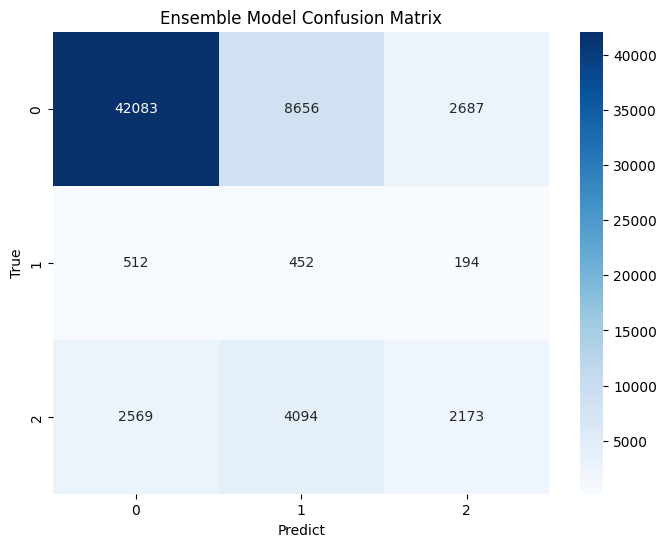

Cascade Model - Class 1 Recall: 0.390, Precision: 0.034
Logistic Regression - Class 1 Recall: 0.990, Precision: 0.020
Ensemble Model - Class 1 Recall: 0.390, Precision: 0.034


In [11]:

# Part 3: Create Ensemble with Cascade Model and Logistic Regression
print("\n--- Creating Ensemble Model ---")

# Create ensemble predictions by combining both models
# We'll weight the models based on their performance on class 1
ensemble_proba = np.zeros((len(X_test), 3))

# Create pseudo-probabilities for cascade model
cascade_pseudo_proba = np.zeros((len(X_test), 3))
for i in range(len(X_test)):
    if cascade_preds[i] == 0:
        cascade_pseudo_proba[i, 0] = 0.8
        cascade_pseudo_proba[i, 1] = 0.15
        cascade_pseudo_proba[i, 2] = 0.05
    elif cascade_preds[i] == 1:
        cascade_pseudo_proba[i, 0] = 0.1
        cascade_pseudo_proba[i, 1] = 0.8
        cascade_pseudo_proba[i, 2] = 0.1
    else:  # Class 2
        cascade_pseudo_proba[i, 0] = 0.05
        cascade_pseudo_proba[i, 1] = 0.15
        cascade_pseudo_proba[i, 2] = 0.8

# Weight the models (giving more weight to cascade for class 1 based on previous results)
ensemble_proba = 0.7 * cascade_pseudo_proba + 0.3 * lr_adjusted_proba

# Boost class 1 probability in the ensemble
ensemble_proba[:, 1] *= 1.25

# Get final ensemble predictions
ensemble_preds = np.argmax(ensemble_proba, axis=1)

print("\nEnsemble Model Classification Report:")
print(classification_report(y_test, ensemble_preds, digits=3))
print("\nEnsemble Model Confusion Matrix:")
print(confusion_matrix(y_test, ensemble_preds))

# Compare all models specifically on class 1 recall
print("\n--- Model Comparison for Class 1 (Prediabetes) ---")
cascade_report = classification_report(y_test, cascade_preds, output_dict=True)
lr_report = classification_report(y_test, lr_adjusted_preds, output_dict=True)
ensemble_report = classification_report(y_test, ensemble_preds, output_dict=True)

# Предсказания модели (например, после коррекции вероятностей)
# lr_adjusted_preds — это твои предсказания

cm = confusion_matrix(y_test, ensemble_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predict')
plt.ylabel('True')
plt.title("Ensemble Model Confusion Matrix")
plt.show()

print(f"Cascade Model - Class 1 Recall: {cascade_report['1.0']['recall']:.3f}, Precision: {cascade_report['1.0']['precision']:.3f}")
print(f"Logistic Regression - Class 1 Recall: {lr_report['1.0']['recall']:.3f}, Precision: {lr_report['1.0']['precision']:.3f}")
print(f"Ensemble Model - Class 1 Recall: {ensemble_report['1.0']['recall']:.3f}, Precision: {ensemble_report['1.0']['precision']:.3f}")